# Predict the Probability for the Export output 1 csv file using RNN model

In [32]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
263/263 [==============================] - 5s 9ms/step - loss: 0.6240 - accuracy: 0.6657 - val_loss: 0.3923 - val_accuracy: 0.8850
Epoch 2/5
263/263 [==============================] - 2s 7ms/step - loss: 0.4377 - accuracy: 0.8063 - val_loss: 0.2654 - val_accuracy: 0.9128
Epoch 3/5
263/263 [==============================] - 2s 7ms/step - loss: 0.3632 - accuracy: 0.8537 - val_loss: 0.2404 - val_accuracy: 0.9194
Epoch 4/5
263/263 [==============================] - 2s 7ms/step - loss: 0.3374 - accuracy: 0.8677 - val_loss: 0.2339 - val_accuracy: 0.9222
Epoch 5/5
57/57 [==============================] - 0s 2ms/step


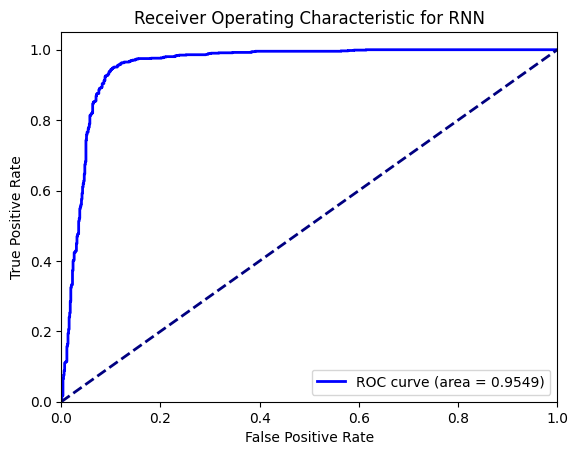

In [33]:
# Now we should use tained model which is RNN in this case so we have to run the model from the scratch
df = pd.read_csv('DATA.csv', names= ['Wildfire', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max',
                                       'soilmois', 'slope', 'ndvi', 'lulc', 'dist_lake', 'evt_aug',
                                       'elevation', 'dist_road', 'dist_river', 'pcp', 'index'
                                                   ], header= 0
                      )
df = df.astype(
    {
        'Wildfire': 'category',
        'twi': 'category',
        'aspect': 'category',
        'temp_july': 'category',
        'temp_max': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'evt_aug': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)
new_order = [
             'index', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max', 'soilmois', 'slope', 'ndvi',
             'lulc', 'dist_lake', 'evt_aug', 'elevation', 'dist_road', 'dist_river', 'pcp',  'Wildfire'
            ]
df = df[new_order]
col_to_drop = ['index', 'X', 'Y']
df = df.drop(columns= col_to_drop, axis= 1)
col_to_drop = ['temp_max', 'evt_aug', 'twi']
df = df.drop(columns= col_to_drop, axis= 1)
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

categorical_columns = [
    'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi', 'lulc',
    'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp'
]

# Prepare the features and target variable without dropping any columns
X = df.drop(['Wildfire'], axis=1)
y = df['Wildfire']

# Split data into training and remaining sets (temporary set for further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42                     )

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit the encoder on training data and transform the training, validation, and test data for categorical columns
encoder.fit(X_train[categorical_columns])
encoded_train = encoder.transform(X_train[categorical_columns])
encoded_val = encoder.transform(X_val[categorical_columns])
encoded_test = encoder.transform(X_test[categorical_columns])

# Convert the encoded features into a DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out(categorical_columns))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the encoded features with the non-categorical data
final_train_df = pd.concat([X_train.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_train_df], axis=1)
final_val_df = pd.concat([X_val.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_val_df], axis=1)
final_test_df = pd.concat([X_test.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_test_df], axis=1)

# Add the target variable 'Wildfire' back to the final datasets
final_train_df['Wildfire'] = y_train.reset_index(drop=True)
final_val_df['Wildfire'] = y_val.reset_index(drop=True)
final_test_df['Wildfire'] = y_test.reset_index(drop=True)
















import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the RNN model
def create_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(8, return_sequences=True, input_shape=input_shape),
        Dropout(0.5),
        SimpleRNN(4, return_sequences=False),  # Only return the final output
        Dropout(0.5),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification
    ])
    return model

# Assuming input_shape based on the final_train_df without the target column
input_shape = (1, final_train_df.shape[1] - 1)  # Only one timestep, features equal to number of columns minus target

# Create the model
model = create_rnn_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Convert target data to float32 to avoid TypeError
y_train = final_train_df['Wildfire'].astype('float32').values
y_val = final_val_df['Wildfire'].astype('float32').values
y_test = final_test_df['Wildfire'].astype('float32').values

# Reshape data to fit the RNN input requirements: [samples, timesteps, features]
X_train = final_train_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_train_df.shape[1] - 1)
X_val = final_val_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_val_df.shape[1] - 1)
X_test = final_test_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_test_df.shape[1] - 1)

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Predict probabilities for ROC curve
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for RNN')
plt.legend(loc="lower right")
plt.show()


In [34]:
df1 = pd.read_csv('Export_Output1_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [35]:
col_to_drop = ['pointid', 'grid_code']
df1 = df1.drop(columns= col_to_drop, axis= 1)

In [36]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4,2,5,4,1,2,1,2,3,45.478238,-80.333373
1,4,4,4,2,5,4,1,2,1,3,3,45.474184,-80.308844
2,4,4,4,2,5,4,1,2,1,3,3,45.470122,-80.284320
3,5,4,4,2,5,4,1,2,0,3,3,45.466055,-80.259800
4,5,4,4,2,5,4,1,2,0,3,3,45.461980,-80.235285


In [37]:
import pandas as pd
import numpy as np

# Assuming your dataframe is named df1
df1.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df1.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      509
slope           0
ndvi          514
lulc            0
dist_lake       0
elevation       0
dist_road      76
dist_river     77
pcp           510
Latitude        0
Longitude       0
dtype: int64


In [38]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df1[df1.isnull().any(axis=1)]
df_not_missing = df1.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df1.columns[df1.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df1.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df1.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [39]:
df1 = df1.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [40]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285


In [41]:
col_to_drop = ['Latitude', 'Longitude']
df1_new = df1.drop(columns= col_to_drop, axis= 1)

In [42]:
df1.shape

(1000001, 13)

In [44]:
df1_new.shape

(1000001, 11)

In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new = encoder.transform(df1_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new = pd.DataFrame(encoded_data_new, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new = pd.concat([df1_new.drop(categorical_columns, axis=1), encoded_df_new], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new = final_df_new.values.reshape(-1, 1, final_df_new.shape[1])

# Load your trained RNN model (if not already loaded)

# Predict using RNN model
predictions = model.predict(X_new)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df = pd.DataFrame(predictions, columns=['Wildfire_Probability'])


31251/31251 [==============================] - 70s 2ms/step


In [46]:
predictions_df.tail(20)

,Wildfire_Probability
999981,0.946037
999982,0.946037
999983,0.949657
999984,0.946927
999985,0.936366
999986,0.948556
999987,0.949152
999988,0.949338
999989,0.947793
999990,0.947793


In [47]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df1['Wildfire_Probability'] = predictions_df['Wildfire_Probability'].values

In [48]:
df1.head(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,Wildfire_Probability
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.054987
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.054883
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.054883
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.074128
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.074128
5,3,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.457899,-80.210774,0.065594
6,4,4,4.0,3,5.0,4,1,2,0.0,3.0,3.0,45.453812,-80.186268,0.105984
7,4,4,4.0,2,5.0,3,1,2,0.0,2.0,3.0,45.449718,-80.161766,0.023898
8,4,4,4.0,2,5.0,4,1,2,0.0,2.0,3.0,45.445617,-80.137269,0.092537
9,4,4,4.0,3,5.0,4,1,2,0.0,2.0,3.0,45.441510,-80.112776,0.104878


In [49]:
df1.tail(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,Wildfire_Probability
999991,5,2,1.0,3,3.0,8,3,3,3.0,4.0,3.0,51.881635,-66.016225,0.931667
999992,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.873640,-65.989881,0.948556
999993,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.865639,-65.963548,0.948556
999994,5,2,1.0,5,3.0,4,3,3,3.0,4.0,3.0,51.857631,-65.937225,0.946027
999995,4,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.849616,-65.910913,0.949152
999996,3,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.841595,-65.884612,0.948192
999997,3,2,1.0,3,3.0,11,3,3,3.0,4.0,3.0,51.833568,-65.858322,0.939470
999998,5,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.825534,-65.832042,0.949067
999999,4,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.817493,-65.805774,0.949657
1000000,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.809446,-65.779515,0.948771


# Predict the Probability for the Export output 2 csv Using RNN model

In [50]:
df2 = pd.read_csv('Export_Output_2_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [51]:
df2.tail()

,pointid,grid_code,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
1017097,2015,43.0,4,1,1,3,2,5,5,1,4,5,1,69.148333,-138.495084
1017098,2016,27.0,3,1,1,2,2,8,5,1,4,5,1,69.159967,-138.454979
1017099,2017,21.0,3,1,1,2,2,5,5,1,4,5,1,69.171592,-138.414832
1017100,2018,14.0,2,1,1,2,2,3,5,1,4,5,1,69.183207,-138.374644
1017101,2019,14.0,2,1,-9999,2,-9999,3,5,1,4,5,-9999,69.194813,-138.334416


In [52]:
col_to_drop = ['pointid', 'grid_code']
df2 = df2.drop(columns= col_to_drop, axis= 1)

In [53]:
df2.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,3,2,1,4,3,4,3,3,3,4,2,51.801392,-65.753268
1,2,2,1,2,3,4,3,3,3,4,3,51.793332,-65.727031
2,3,2,1,4,3,5,3,3,3,4,3,51.785265,-65.700805
3,4,2,1,3,3,5,3,3,3,4,3,51.777192,-65.674590
4,5,2,1,2,3,4,3,3,3,4,3,51.769113,-65.648385


In [54]:
import pandas as pd
import numpy as np

# Assuming your dataframe is named df1
df2.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df2.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      879
slope           0
ndvi          859
lulc            0
dist_lake       0
elevation       0
dist_road     124
dist_river    124
pcp           881
Latitude        0
Longitude       0
dtype: int64


In [55]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df2[df2.isnull().any(axis=1)]
df_not_missing = df2.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df2.columns[df2.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df2.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df2.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [56]:
df2 = df2.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [57]:
df2.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,3,2,1.0,4,3.0,4,3,3,3.0,4.0,2.0,51.801392,-65.753268
1,2,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.793332,-65.727031
2,3,2,1.0,4,3.0,5,3,3,3.0,4.0,3.0,51.785265,-65.700805
3,4,2,1.0,3,3.0,5,3,3,3.0,4.0,3.0,51.777192,-65.674590
4,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.769113,-65.648385


In [58]:
df2.tail()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
1017097,4,1,1.0,3,2.0,5,5,1,4.0,5.0,1.0,69.148333,-138.495084
1017098,3,1,1.0,2,2.0,8,5,1,4.0,5.0,1.0,69.159967,-138.454979
1017099,3,1,1.0,2,2.0,5,5,1,4.0,5.0,1.0,69.171592,-138.414832
1017100,2,1,1.0,2,2.0,3,5,1,4.0,5.0,1.0,69.183207,-138.374644
1017101,2,1,1.0,2,2.0,3,5,1,4.0,5.0,1.0,69.194813,-138.334416


In [59]:
col_to_drop = ['Latitude', 'Longitude']
df2_new = df2.drop(columns= col_to_drop, axis= 1)

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new2 = encoder.transform(df2_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new2 = pd.DataFrame(encoded_data_new2, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new2 = pd.concat([df2_new.drop(categorical_columns, axis=1), encoded_df_new2], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new2 = final_df_new2.values.reshape(-1, 1, final_df_new2.shape[1])

# Load your trained RNN model (if not already loaded)

# Predict using RNN model
predictions = model.predict(X_new2)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df2 = pd.DataFrame(predictions, columns=['Wildfire_Probability'])


31785/31785 [==============================] - 79s 2ms/step


In [62]:
predictions_df2.tail(20)

,Wildfire_Probability
1017082,0.285587
1017083,0.079359
1017084,0.088844
1017085,0.098138
1017086,0.465996
1017087,0.087870
1017088,0.376080
1017089,0.076448
1017090,0.087870
1017091,0.087870


In [63]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df2['Wildfire_Probability'] = predictions_df2['Wildfire_Probability'].values

In [64]:
df2.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,Wildfire_Probability
0,3,2,1.0,4,3.0,4,3,3,3.0,4.0,2.0,51.801392,-65.753268,0.950250
1,2,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.793332,-65.727031,0.948563
2,3,2,1.0,4,3.0,5,3,3,3.0,4.0,3.0,51.785265,-65.700805,0.941608
3,4,2,1.0,3,3.0,5,3,3,3.0,4.0,3.0,51.777192,-65.674590,0.945923
4,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.769113,-65.648385,0.948771


In [65]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,Wildfire_Probability
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.054987
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.054883
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.054883
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.074128
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.074128


In [66]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp']
df1_final = df1.drop(columns= col_to_drop, axis= 1)

In [67]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp']
df2_final = df2.drop(columns= col_to_drop, axis= 1)

In [71]:
df1_final.tail()

,Latitude,Longitude,Wildfire_Probability
999996,51.841595,-65.884612,0.948192
999997,51.833568,-65.858322,0.939470
999998,51.825534,-65.832042,0.949067
999999,51.817493,-65.805774,0.949657
1000000,51.809446,-65.779515,0.948771


In [70]:
df2_final.tail()

,Latitude,Longitude,Wildfire_Probability
1017097,69.148333,-138.495084,0.025596
1017098,69.159967,-138.454979,0.019829
1017099,69.171592,-138.414832,0.022695
1017100,69.183207,-138.374644,0.019420
1017101,69.194813,-138.334416,0.019420
